# Imports

In [4]:
import tensorflow as tf
import tensorflowjs as tfjs
AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display
from PIL import Image
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow import keras
import cv2

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Generation: Face Detection

The training images were downloaded from Instagram with hashtags like #beardchallenge, #beardforayear, #beardjourney, #noshavenovember and hashtaks like #day1, #day2 indicating the label. Then the CV2 face detection is used to crop these instagram images.

In [ ]:
face_cascade = cv2.CascadeClassifier('/content/drive/My Drive/Colab Notebooks/beard_growth_AI/haarcascade_frontalface_default.xml')
IMG_HEIGHT = 224
IMG_WIDTH = 224
def face_train(file_path):
  # Read the input image
  img = cv2.imread(file_path)
  # Convert into grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # Detect faces
  faces = face_cascade.detectMultiScale(gray, 1.1, 4)
  list1 = file_path.split("/")
  list1[7] ='train_face'
  file_save = '/'.join(list1)

  im = Image.open(file_path,mode='r') 
  width, height = im.size 
  
  print(faces)
  if(len(faces)!=0):
    # Setting the points for cropped image
    increase = int(((faces[0][0] + faces[0][2])*0.12)/2) 
    left = faces[0][0] - increase
    top = faces[0][1]
    right = faces[0][0] + faces[0][2] + increase
    bottom = top + faces[0][3] + increase * 2
      
    # Cropped image of above dimension 
    # (It will not change orginal image) 
    im1 = im.crop((left, top, right, bottom))

    im2 = im1.resize((IMG_HEIGHT,IMG_WIDTH))

    im2.save(file_save)
  else:
    print('No Face')

In [ ]:
#list_ds = tf.data.Dataset.list_files("../data/train/*.jpg") 
list_ds = tf.data.Dataset.list_files("/content/drive/My Drive/Colab Notebooks/beard_growth_AI/data/train/*.jpg")

for f in list_ds:
      print(f.numpy().decode("utf-8"))
      face_train(f.numpy().decode("utf-8"))

/content/drive/My Drive/Colab Notebooks/beard_growth_AI/data/train/30_hugothebeard.jpg
[[ 58  47 128 128]]
/content/drive/My Drive/Colab Notebooks/beard_growth_AI/data/train/3_Abeardforayear.jpg
[[ 58  44 136 136]]
/content/drive/My Drive/Colab Notebooks/beard_growth_AI/data/train/3_Bbeardforayear.jpg
[[ 38  24 178 178]]
/content/drive/My Drive/Colab Notebooks/beard_growth_AI/data/train/48_igrowmybeardout.jpg
[[ 30  54 150 150]]
/content/drive/My Drive/Colab Notebooks/beard_growth_AI/data/train/50_igrowmybeardout.jpg
[[ 27  41 166 166]]
/content/drive/My Drive/Colab Notebooks/beard_growth_AI/data/train/1_Abeardforayear.jpg
[[81 77 97 97]]
/content/drive/My Drive/Colab Notebooks/beard_growth_AI/data/train/21_PersonC.jpg
[[ 47  48 131 131]]
/content/drive/My Drive/Colab Notebooks/beard_growth_AI/data/train/44_Abeardforayear.jpg
[[ 74  64 128 128]]
/content/drive/My Drive/Colab Notebooks/beard_growth_AI/data/train/14_Bbeardforayear.jpg
()
No Face
/content/drive/My Drive/Colab Notebooks/be

# Preprocessing

The label and image are loaded and augmented to generate more images for training

In [6]:
#list_ds = tf.data.Dataset.list_files("../data/train/*.jpg") 
list_ds = tf.data.Dataset.list_files("/content/drive/My Drive/Colab Notebooks/beard_growth_AI/data/train_face/*.jpg")

for f in list_ds.take(5):
      print(f.numpy())

b'/content/drive/My Drive/Colab Notebooks/beard_growth_AI/data/train_face/6_Abeardforayear.jpg'
b'/content/drive/My Drive/Colab Notebooks/beard_growth_AI/data/train_face/38_hugothebeard.jpg'
b'/content/drive/My Drive/Colab Notebooks/beard_growth_AI/data/train_face/38_thebeardobrien.jpg'
b'/content/drive/My Drive/Colab Notebooks/beard_growth_AI/data/train_face/40_igrowmybeardout.jpg'
b'/content/drive/My Drive/Colab Notebooks/beard_growth_AI/data/train_face/13_PersonB.jpg'


In [7]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMAGE_SHAPE = (IMG_HEIGHT, IMG_WIDTH)

def get_label(file_path):
  # convert the path to a list of path components
  #Get the file number as the label  
    part1 = tf.strings.split(file_path, os.path.sep)
    part2 = tf.strings.split(part1[8],"_")
    return int(part2[0]) #== Beard_Length

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

#Use Dataset.map to create a dataset of image, label pairs:

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in labeled_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  8
Image shape:  (224, 224, 3)
Label:  26
Image shape:  (224, 224, 3)
Label:  13
Image shape:  (224, 224, 3)
Label:  16
Image shape:  (224, 224, 3)
Label:  22


In [8]:
DATASET_SIZE = 318
train_size = int(0.8 * DATASET_SIZE)
test_size = int(0.2 * DATASET_SIZE)
train_dataset = labeled_ds.take(train_size)
test_dataset = labeled_ds.skip(train_size)

In [9]:
train_images = []
train_labels = []
for image, label in train_dataset.take(train_size):
    train_images.append(image.numpy())
    train_labels.append(label.numpy())
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [10]:
test_images = []
test_labels = []
for image, label in test_dataset.take(test_size):
    test_images.append(image.numpy())
    test_labels.append(label.numpy())
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [11]:
def show_batch(image_batch, label_batch, batch_s):
    plt.figure(figsize=(10,10))
    for n in range(batch_s):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(label_batch[n])
        plt.axis('off')

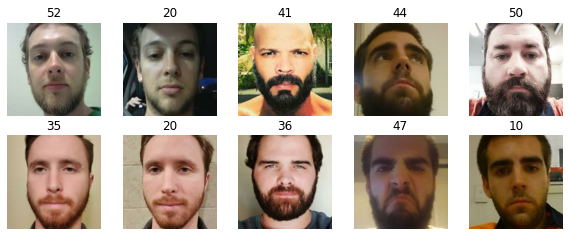

In [12]:
batch_s =10
show_batch(test_images,test_labels, batch_s)

In [13]:
batch_training = 32
image_gen_train = ImageDataGenerator(
                   rotation_range= 10,
                   width_shift_range=.1,
                   height_shift_range=.1,
                   horizontal_flip=True,
                   zoom_range=0.1,
                   channel_shift_range=0.2
                    )

In [14]:
train_data_gen = image_gen_train.flow(train_images, train_labels, shuffle = True,batch_size=batch_training)

In [15]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

In [16]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

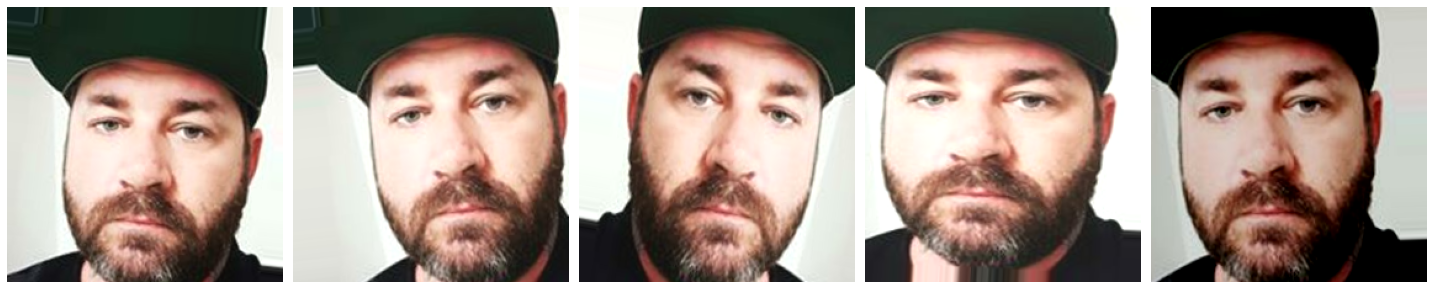

In [17]:
plotImages(augmented_images)

# Model

A pretrained feature extraction layer is chosen as the first layer to decrease the training time. As the goal is to predict a numeric value for the days a single node at the end is chosen, with an relu activation function and the Adam optimization function.

In [33]:
feature_extractor_layer = hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
                                         input_shape=IMAGE_SHAPE+(3,),
                                           trainable=False) #, arguments=dict(batch_norm_momentum=0.9985))

In [34]:
model = Sequential([
    feature_extractor_layer,
    Dense(512, activation='relu'), 
    Dense(1)
])

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               655872    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 2,914,369
Trainable params: 656,385
Non-trainable params: 2,257,984
_________________________________________________________________


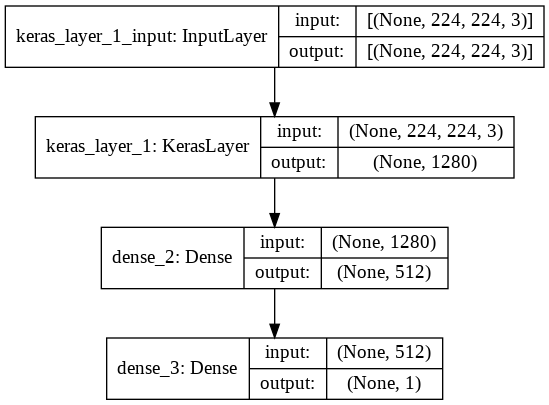

In [36]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

In [37]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mean_absolute_error']
             )

In [38]:
log_dir = "content/drive/My Drive/Colab Notebooks/beard_growth_AI/model/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Training

The model is trained and evaluated.

In [39]:
epochs = 110
model.fit(
    train_data_gen,
    steps_per_epoch= train_size // batch_training, 
    epochs=epochs,
    validation_data=(test_images,test_labels),
    validation_steps=test_size // batch_training,
    callbacks=[tensorboard_callback]
)

Epoch 1/110
7/7 [==============================] - 17s 2s/step - loss: 567.2839 - mean_absolute_error: 19.3770 - val_loss: 222.6878 - val_mean_absolute_error: 12.5450
Epoch 2/110
7/7 [==============================] - 11s 2s/step - loss: 285.6374 - mean_absolute_error: 14.3911 - val_loss: 257.9612 - val_mean_absolute_error: 13.5473
Epoch 3/110
7/7 [==============================] - 11s 2s/step - loss: 222.1903 - mean_absolute_error: 12.3343 - val_loss: 225.2209 - val_mean_absolute_error: 12.6789
Epoch 4/110
7/7 [==============================] - 11s 2s/step - loss: 185.5646 - mean_absolute_error: 11.7540 - val_loss: 154.2987 - val_mean_absolute_error: 10.4141
Epoch 5/110
7/7 [==============================] - 11s 2s/step - loss: 194.2228 - mean_absolute_error: 12.0081 - val_loss: 171.1452 - val_mean_absolute_error: 10.8904
Epoch 6/110
7/7 [==============================] - 11s 2s/step - loss: 163.8221 - mean_absolute_error: 10.6043 - val_loss: 147.3034 - val_mean_absolute_error: 10.040

In [40]:
model.evaluate(test_images,test_labels, verbose=2)

2/2 - 3s - loss: 24.8535 - mean_absolute_error: 4.0052


[24.853500366210938, 4.005169868469238]

In [41]:
predictions = pd.DataFrame(model.predict(test_images))

In [42]:
test_label = pd.DataFrame(test_labels)
pred_df = pd.concat([predictions,test_label],axis=1)
pred_df.columns = ["predictions","test_label"]

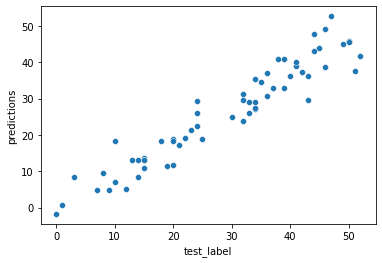

In [43]:
sns.scatterplot(x='test_label',y='predictions',data=pred_df)

# Deployment

In order to use the model for an webapp, it is converted to a tensorflow js graph model.

In [44]:
!mkdir -p saved_model
model.save('/content/drive/My Drive/Colab Notebooks/beard_growth_AI/model/saved_model_2')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/beard_growth_AI/data/model/saved_model_2/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/beard_growth_AI/data/model/saved_model_2/assets


In [ ]:
tfjs.converters.convert_tf_saved_model('/content/drive/My Drive/Colab Notebooks/beard_growth_AI/model/saved_model_2', "/content/drive/My Drive/Colab Notebooks/beard_growth_AI/model/graph_model_2")

Writing weight file /content/drive/My Drive/Colab Notebooks/beard_growth_AI/data/model/graph_model_2/model.json...


# Test other images

In [48]:
list_test_img = tf.data.Dataset.list_files("/content/drive/My Drive/Colab Notebooks/beard_growth_AI/data/run_images/*.jpg")
for f in list_test_img.take(4):
      print(f.numpy())

b'/content/drive/My Drive/Colab Notebooks/beard_growth_AI/data/run_images/0_WIN_20200410_14_38_30_Pro.jpg'
b'/content/drive/My Drive/Colab Notebooks/beard_growth_AI/data/run_images/100_WIN_20200407_23_48_49_Pro.jpg'
b'/content/drive/My Drive/Colab Notebooks/beard_growth_AI/data/run_images/100_WIN_20200407_23_48_39_Pro.jpg'
b'/content/drive/My Drive/Colab Notebooks/beard_growth_AI/data/run_images/100_WIN_20200407_23_48_45_Pro.jpg'


In [49]:
labeled_test_img = list_test_img.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in labeled_test_img.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  0
Image shape:  (224, 224, 3)
Label:  100
Image shape:  (224, 224, 3)
Label:  30
Image shape:  (224, 224, 3)
Label:  100
Image shape:  (224, 224, 3)
Label:  100


In [50]:
test_size = 5
me_test_images = []
me_test_labels = []
for image, label in labeled_test_img.take(test_size):
    #print("Image shape: ", image.numpy().shape)
    me_test_images.append(image.numpy())
    #print("Label: ", label.numpy())
    me_test_labels.append(label.numpy())
me_test_images = np.array(me_test_images)
me_test_labels = np.array(me_test_labels)

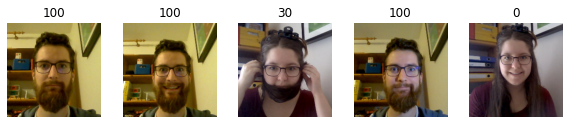

In [51]:
show_batch(me_test_images, me_test_labels, test_size)

In [52]:
predictions_me = pd.DataFrame(model.predict(me_test_images))

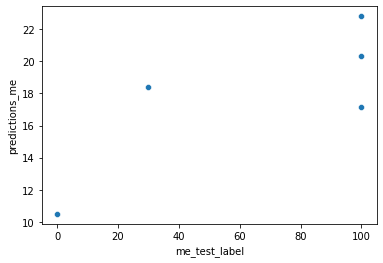

In [53]:
me_test_label = pd.DataFrame(me_test_labels)
pred_df = pd.concat([predictions_me,me_test_label],axis=1)
pred_df.columns = ["predictions_me","me_test_label"]
sns.scatterplot(x='me_test_label',y='predictions_me',data=pred_df)